## Final Project Submission

Please fill out:
* Student's names: Charlie Loshe, Ali Rampurawala, Mitch Allison
* Student pace: full time
* Instructor name: David Elliott
* Github repo: https://github.com/AliRampur/Phase-2-Group-Project


#### Import necessary packages, setup dataframe

In [1]:
#imports

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from mpl_toolkits import mplot3d
import statsmodels.api as sm

import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.diagnostic import linear_rainbow

%matplotlib inline

In [2]:
df = pd.read_csv('./data/kc_house_data.csv',
                parse_dates=['date'])

# Overview

For this project, we use multiple linear regression modeling to analyze house sales in a King County, a large county located in the State of Washington.

# Business Problem
King County Development LLC is a new residential real estate developer trying to enter the market. They have engaged us to help them analyze recent sales data and provide recommendations on how to best enter the market (types of houses, location, build quality, etc). Specifcally, they've asked that we focus on single family homes, consider areas near a business center (i.e., Seattle), and consider luxury homes in our analysis, in addition to your more common homes in the area.

We're looking to find answers to the following buisiness problems:

- Identify the most important metrics that effect housing prices(highest correlation).

- Build a predictive and an inferential model.

- Explain the process for reaching our conclusions.

# Exploratory Data Analysis (EDA)

With the data loaded, we're able to perform EDA.
Our business problem is concerned specifically with single family luxury homes near business/population centers, so we'll cut out data that doesn't help to answer this question.


This dataset contains every type of variable: continuous, discrete, and categorical. The categorical variables can be ordinal, binary, or standard. We used OneHotEncoder and OrdinalEncoder to help deal with categorical values so that we can perform regression on them.

We also noted that our target does appear to have a non-normal distribution, but have decided to keep it unaltered for now to more easily explain the results of the model to stakeholders.


Finally, we've also changed some columns to binary values to help us answer our business questions.
Our changes to the dataframe are as follows:

`id` - DEL

`date` - DATETIME(only needed to screen irregular build dates)

`price` - Sale price (prediction target)
Is normally distributed at lower prices, but has many outliers over 2.3mil.
Houses sold at outlier amounts are removed.

`bedrooms` - Number of bedrooms

`bathrooms` - Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom).
Change 0 bathroom to 1 bathroom. Round up other values.

`sqft_living` - Square footage of living space in the home

`sqft_lot` - DEL

`floors` - DEL

`waterfront` - ONEHOT

`greenbelt` - BINARY

`nuisance` - BINARY

`view` - ORDINAL

`condition` - ORDINAL

`grade` - ORDINAL

`heat_source` - DEL

`sewer_system` - BINARY

`sqft_above` - DEL

`sqft_basement` - BINARY

`sqft_garage` - BINARY

`sqft_patio` - BINARY

`yr_built` - Year when house was built

`yr_renovated` - BINARY

`address` - GET ZIP, ONEHOT

`lat` - DEL

`long` - DEL

## Cleaning the dataframe, performing encoding, and engineering new variables
Here we perform the necessary transformations to the data.

In [3]:
df.drop(['id', 'floors',
         'heat_source','lat','long'], axis=1, inplace=True)

# Create zip from address
df['zip'] = [x.split(',')[2][-5:] for x in df['address']] 

#https://www.zillow.com/browse/homes/wa/king-county/  - remove all records with zipcodes that dont start with '98'
df = df[df.zip.str.startswith(('98'))]

df['city'] = [x.split(',')[1][0:] for x in df['address']]

#create sale year column from datetime date info
df['sale_year'] = pd.DatetimeIndex(df['date']).year.astype(int)

df['sale_year'].value_counts()


#create new column - age of house
df['home_age'] = (df['sale_year']+1) - df['yr_built']

#create new column - time since reno
df['yr_from_reno'] = (df['sale_year']+1) - df['yr_renovated']

# create filter for yr_from_reno to ID houses that haven't been renovated
reno_filter = df['yr_from_reno'] > 2000

# create new column for design_age to see time since build if no reno, or time since reno if renovated
# first set to reno age
df['design_age'] = df['yr_from_reno']
#then update columns where there was no reno to age of the home
df['design_age'].loc[reno_filter] = df['home_age']

#some houses were sold before they were built - we need to change those records to 0

prebuild_filter = df['design_age'] < 1

df['design_age'].loc[prebuild_filter] = 1


grade_cat = df[['grade']]
grade_categories = ['1 Cabin', '2 Substandard', '3 Poor', '4 Low', '5 Fair', '6 Low Average',
                    '7 Average', '8 Good', '9 Better', '10 Very Good', '11 Excellent', '12 Luxury', '13 Mansion']
encoder_grade = OrdinalEncoder(categories=[grade_categories])
encoder_grade.fit(grade_cat)
grade_encoded_train = encoder_grade.transform(grade_cat)
grade_encoded_train = grade_encoded_train.flatten()
df["grade"] = grade_encoded_train


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


We found that these engineered variables were necessary to help improve the dataframe later on. We haven't included all iterations to get to this point, as we created 20+ models until arriving at the best models.

`city` - extracted from `address`. ONEHOT

`design_age` - (ordinal)If renovated, time since renovated. If not renovated, time since built. ONEHOT

We also screened `grade` between 'Good' and 'Excellent', as these are the types of homes that our client is looking to build. 'Good' is considered to be of average construction and design. Values above 'Excellent' are considered to be outside of our scope, as these homes become overly luxurious for most single families.

In [4]:
grade_filter1 = df["grade"] > 5 
grade_filter2 = df["grade"] < 11
df = df.loc[grade_filter1 & grade_filter2]

We screened `city` by cities with 30+ sales. This defines a definite need for homes in that area, and gives us a good dataset for that area.

In [5]:
df_city = df.groupby('city').count()['price'].reset_index()
city_columns = df_city[ df_city['price'] >= 30 ].transpose()
city_columns.columns = city_columns.iloc[0]

drop_city = df.groupby('city').count()['price'].reset_index()
drop_city_columns = drop_city[ drop_city['price'] < 30 ].transpose()
drop_city_columns.columns = drop_city_columns.iloc[0]

drop_city = list(drop_city_columns.columns)

for city in drop_city:
    df = df[~df.city.str.contains(city)]

According to the zoning proposal below, small, single family (larger cottage style) homes have a total square feet of 1,400 - assuming garage is the only non-living area, and the average 2 car garage is 360 sqft(from Jerry above).

We've screened our data by minimim living sqft above 1100, giving some flexibility for garage space.
Given the fact that we're not building mansions, just single family homes, if we build detached homes with total area of 2200 sqft, we'd get access to the FAR preservation incentive.

https://www.seattle.gov/Documents/Departments/SDCI/Codes/SingleFamilyZoningSummary.pdf
https://getjerry.com/questions/how-many-square-feet-is-a-2-car-garage

In [6]:
sqft_filter1 = df["sqft_living"] > 1100

df = df.loc[sqft_filter1]

To determine what variables we wanted to include in our model, we looked at the correlation between the different variables and price. This first look helps us eliminate collinearity and focus on variables that will be statistically significant to the model.

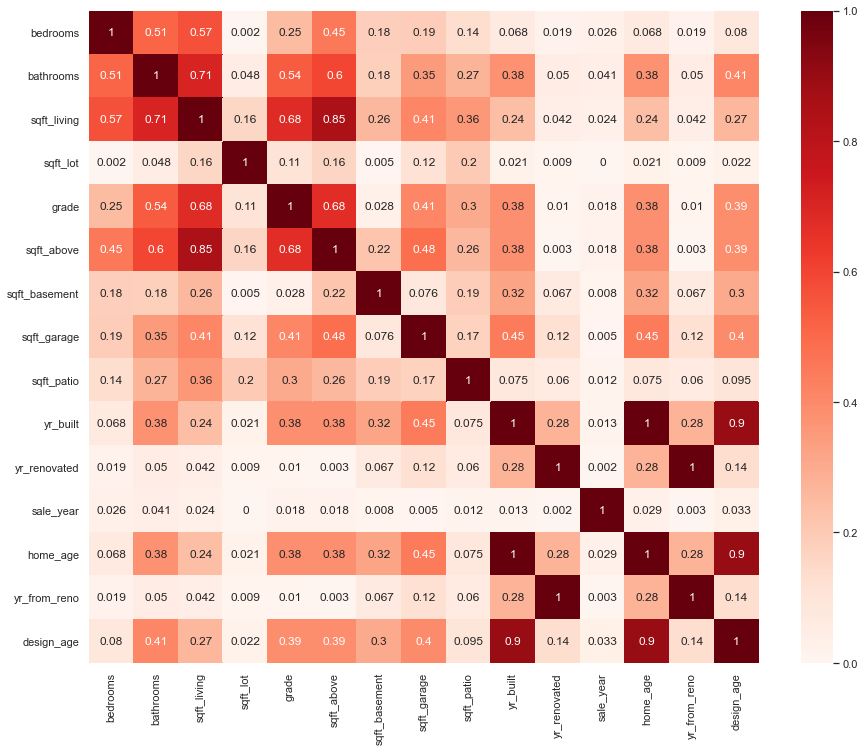

In [7]:
df_predictors = df.drop(columns=['price'])
corr = round(abs(df_predictors.corr()),3)
sns.set(rc = {'figure.figsize':(15,12)})
sns.heatmap(corr, cmap="Reds", annot=True);

### Seperate data into train and test sets
We now seperate the data into training and test sets. We do this now so that there is no data leakage between the training and testing sets. We do need to do some additional cleaning/engineering after creating the subsets.

In [8]:
y = df["price"]
X = df.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)

# Finish applying engineering and transformations to data set
We now apply OrdinalEncoder and OneHotEncoder to the variables that need them. There are a lot of transformations and engineered variables created here.

`zip` - extracted from address. ONEHOT

`total_sqft` - `sqft_above` + `sqft_basement` + `sqft_garage` + `sqft_patio`

We'll look more at it later, but we found that multiplying grade by other variables allowed us to create weighted values. We also created additional weighted values by multiplying/dividing other variables. These weighted values are more effective at creating a good model than each variable acting by itself.

`weighted_livsqft` - `sqft_living` * `grade`

`design_decade` - `design_age` grouped by decade. Can be considered categorical. ORDINAL

`view_grade` - `view` * `grade`

`waterfront_grade` - `waterfront_binary` * `grade`

`design_decade_grade` - `design_decade` * `grade`

`nuisance_grade` - `nuisance` * `grade`

`garage_binary_grade` - `garage_binary` * `grade`

`basement_binary_grade` - `basement_binary` * `grade`

`patio_binary_grade` - `patio_binary` * `grade`

`PublicSewer_binary_grade` - `PublicSewer_binary` * `grade`

`condition_grade` - `condition` * `grade`

`yard_size_ratio` - `total_sqft` / `sqft_lot`

In [9]:
# Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom). Change 0 bathroom to 1 bathroom. Round up other values.
X_train.loc[X_train['bathrooms'] == 0, 'bathrooms'] = 1
X_train['bathrooms'] = X_train['bathrooms'].apply(np.ceil)


# Create binary substitutes for columns
X_train['basement_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_basement']]
X_train['garage_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_garage']]
X_train['patio_binary'] = [1 if sq >  0  else 0 for sq in X_train['sqft_patio']]
X_train['waterfront_binary'] = [1 if sq == 'YES'  else 0 for sq in X_train['waterfront']]
X_train['PublicSewer_binary'] = [1 if sq == 'PUBLIC' else 0 for sq in X_train['sewer_system']]
X_train['yrenovated_binary'] = [1 if sq >  0 else 0 for sq in X_train['yr_renovated']]


# Create binary values for greenbelt
# Using OneHotEncoder
greenbelt_cat = X_train[['greenbelt']]
encoder_greenbelt = OrdinalEncoder(categories=[['NO', 'YES']])
encoder_greenbelt.fit(greenbelt_cat)
greenbelt_encoded_train = encoder_greenbelt.transform(greenbelt_cat)
greenbelt_encoded_train = greenbelt_encoded_train.flatten()
# greenbelt_encoded_train
X_train["greenbelt"] = greenbelt_encoded_train


# Create binary values for nuisance
# Using OneHotEncoder
nuisance_cat = X_train[['nuisance']]
encoder_nuisance = OrdinalEncoder()
encoder_nuisance.fit(nuisance_cat)
nuisance_encoded_train = encoder_nuisance.transform(nuisance_cat)
nuisance_encoded_train = nuisance_encoded_train.flatten()
X_train["nuisance"] = nuisance_encoded_train


# Create Ordinal Values for condition
# Using OrdinalEncoder
condition_cat = X_train[['condition']]
condition_categories = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
encoder_condition = OrdinalEncoder(categories=[condition_categories])
encoder_condition.fit(condition_cat)
condition_encoded_train = encoder_condition.transform(condition_cat)
condition_encoded_train = condition_encoded_train.flatten()
X_train["condition"] = condition_encoded_train


# Create Ordinal Values for view
# Using OneHotEncoder
view_cat = X_train[['view']]
view_categories = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
encoder_view = OrdinalEncoder(categories=[view_categories])
encoder_view.fit(view_cat)
view_encoded_train = encoder_view.transform(view_cat)
view_encoded_train = view_encoded_train.flatten()
X_train["view"] = view_encoded_train


# Create onehot columns for `city`
# extracted from `address`
# Using OneHotEncoder
city_train = X_train[["city"]]
ohe_city = OneHotEncoder(categories="auto",
                    sparse=False,
                    handle_unknown="ignore")
ohe_city.fit(city_train)
city_encoded_train = ohe_city.transform(city_train)
city_encoded_train = pd.DataFrame(
    city_encoded_train,
    columns=ohe_city.categories_[0],
    index=X_train.index
)
X_train.drop("city", axis=1, inplace=True)
X_train = pd.concat([X_train, city_encoded_train], axis=1)


# Create onehot columns for `zip`
# extracted from `address`
# Using OneHotEncoder
fireplace_qu_train = X_train[["zip"]]
ohe_zip = OneHotEncoder(categories="auto",
                    sparse=False,
                    handle_unknown="ignore")
ohe_zip.fit(fireplace_qu_train)
fireplace_qu_encoded_train = ohe_zip.transform(fireplace_qu_train)
fireplace_qu_encoded_train = pd.DataFrame(
    fireplace_qu_encoded_train,
    columns=ohe_zip.categories_[0],
    index=X_train.index
)
X_train.drop("zip", axis=1, inplace=True)
X_train = pd.concat([X_train, fireplace_qu_encoded_train], axis=1)


# Create 'total_sqft' by combining sqft_above + sqft_basement + 
# sqft_garage + sqft_patio
X_train['total_sqft'] = X_train['sqft_above'] + X_train['sqft_basement'] + X_train['sqft_garage'] + X_train['sqft_patio']


# Create 'weighted_livsqft' by multiplying 'sqft_living' * 'grade'
X_train['weighted__livsqft'] = X_train['sqft_living'] * X_train['grade']


# Convert 'date' to datetime
X_train['date'] = pd.to_datetime(X_train['date'], format='%Y-%m-%d')


# Create 'sale_year' from datetime date info
X_train['sale_year'] = pd.DatetimeIndex(X_train['date']).year.astype(int)


# Bin 'design_age' by decade into 'design_decade', as they can be considered categorical
X_train['design_decade'] = pd.cut(x=X_train['design_age'], bins=[0, 3, 13, 23, 33, 43, 53, 63, 73,
                                                         83, 93, 103, 113, 123],
                    labels=['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s',
                            '1950s', '1940s', '1930s', '1920s', '1910s', '1900s'])
labels_ordered = ['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s','1950s', '1940s', '1930s', '1920s', '1910s', '1900s']
labels_ordered.reverse()


# Create onehot columns for 'design_decade'
# Using OneHotEncoder
age_cat = X_train[['design_decade']]
age_categories = labels_ordered
encoder_age = OrdinalEncoder(categories=[age_categories])
encoder_age.fit(age_cat)
encoder_age.categories_[0]
age_encoded_train = encoder_age.transform(age_cat)
age_encoded_train = age_encoded_train.flatten()
X_train["design_decade"] = age_encoded_train


# Create 'yard_size_ratio', by dividing 'sqft_lot' by 'total_sqft' to get a ratio of size of house to size of lot
X_train['yard_size_ratio'] = (X_train['total_sqft'] / X_train['sqft_lot']) * 100

X_train['view_grade'] = (X_train['view'] + 1) * X_train['grade']
X_train['waterfront_grade'] = (X_train['waterfront_binary'] + 1)  * X_train['grade']
X_train['design_decade_grade'] = (X_train['design_decade'] + 1)  * X_train['grade']
X_train['nuisance_grade'] = (X_train['nuisance'] + 1)  * X_train['grade']
X_train['garage_binary_grade'] = (X_train['garage_binary'] + 1)  * X_train['grade']
X_train['basement_binary_grade'] = (X_train['basement_binary'] + 1)  * X_train['grade']
X_train['patio_binary_grade'] = (X_train['patio_binary'] + 1)  * X_train['grade']
X_train['PublicSewer_binary_grade'] = (X_train['PublicSewer_binary'] + 1)  * X_train['grade']
X_train['condition_grade'] = (X_train['condition'] + 1)  * X_train['grade']

C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-9-4c9dc1b85bfb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['bathrooms'] = X_train['bathrooms'].apply(np.ceil)
<ipython-input-9-4c9dc1b85bfb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

# Why create the x * grade engineered variables?

Throughout our work, we found that multiplying grade times other variables, such as `sqft_living`, provided a higher correlation to price than with `sqft_living` alone. We've illustrated this with the graph below.

![image](https://github.com/AliRampur/Phase-2-Group-Project/blob/main/pics/eng_space.png)

# Creating the prediction model
At this point we have cleaned the training data and are able to perform regression and analyze the data. We found the below columns to be the most effective at creating a good prediction model.

In [10]:
relevant = [' Auburn', ' Bellevue', ' Black Diamond', ' Bothell', ' Burien',
           ' Carnation', ' Clyde Hill', ' Covington', ' Des Moines', ' Duvall',
           ' Enumclaw', ' Fall City', ' Federal Way', ' Issaquah', ' Kenmore',
           ' Kent', ' Kirkland', ' Lake Forest Park', ' Maple Valley', ' Medina',
           ' Mercer Island', ' Newcastle', ' Normandy Park', ' North Bend',
           ' Pacific', ' Ravensdale', ' Redmond', ' Renton', ' Sammamish',
           ' SeaTac', ' Seattle', ' Shoreline', ' Snoqualmie', ' Tukwila',
           ' Vashon', ' Woodinville',
            'weighted__livsqft', 'yard_size_ratio', 'view_grade',
            'waterfront_grade', 'design_decade_grade', 'nuisance_grade', 'garage_binary_grade',
            'basement_binary_grade', 'PublicSewer_binary_grade', 'condition_grade']

X_train = X_train[relevant]

model_train = sm.OLS(y_train, sm.add_constant(X_train)).fit()
results_train = model_train.summary()
results_train

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     728.5
Date:                Sat, 06 Aug 2022   Prob (F-statistic):               0.00
Time:                        21:52:35   Log-Likelihood:            -2.6417e+05
No. Observations:               18192   AIC:                         5.284e+05
Df Residuals:                   18146   BIC:                         5.288e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -2.601e+05    2.9e+04     -8.952      0.000   -3.17e+05   -2.03e+05
 Auburn                  -4.918e+05   1.72e+04    -28.648      0.000   -5.25e+05   -4.58e+05
 Bellevue                 4.814e+05   1.67e+04     28.741      0.000    4.49e+05    5.14e+05
 Black Diamond           -5.091e+05   3.56e+04    -14.298      0.000   -5.79e+05   -4.39e+05
 Bothell                  2.221e+04   3.42e+04      0.650      0.516   -4.48e+04    8.92e+04
 Burien                  -3.368e+05   2.93e+04    -11.475      0.000   -3.94e+05   -2.79e+05
 Carnation               -2.491e+05   4.93e+04     -5.058      0.000   -3.46e+05   -1.53e+05
 Clyde Hill               2.389e+06   7.21e+04     33.115      0.000    2.25e+06    2.53e+06
 Covington               -3.952e+05   2.86e+04    -13.835      0.000   -4.51e+05   -3.39e+05
 Des Moines              -3.904e+05   3.09e+04    -12.629      0.000   -4.51e+05    -3.3e+05
 Duvall                  -2.501e+05   3.69e+04     -6.782      0.000   -3.22e+05   -1.78e+05
 Enumclaw                -4.582e+05   3.09e+04    -14.835      0.000   -5.19e+05   -3.98e+05
 Fall City                2.842e+05   5.94e+04      4.781      0.000    1.68e+05    4.01e+05
 Federal Way             -5.102e+05   1.88e+04    -27.130      0.000   -5.47e+05   -4.73e+05
 Issaquah                 6.352e+04   2.58e+04      2.460      0.014    1.29e+04    1.14e+05
 Kenmore                 -9.022e+04   3.14e+04     -2.876      0.004   -1.52e+05   -2.87e+04
 Kent                     -4.29e+05   1.63e+04    -26.314      0.000   -4.61e+05   -3.97e+05
 Kirkland                 4.054e+05   1.77e+04     22.962      0.000    3.71e+05     4.4e+05
 Lake Forest Park        -1.031e+05   3.85e+04     -2.679      0.007   -1.78e+05   -2.77e+04
 Maple Valley            -3.377e+05   2.05e+04    -16.458      0.000   -3.78e+05   -2.98e+05
 Medina                   2.437e+06   8.92e+04     27.324      0.000    2.26e+06    2.61e+06
 Mercer Island            6.616e+05   3.19e+04     20.769      0.000    5.99e+05    7.24e+05
 Newcastle               -5.755e+04    4.2e+04     -1.370      0.171    -1.4e+05    2.48e+04
 Normandy Park           -3.876e+05   5.61e+04     -6.910      0.000   -4.98e+05   -2.78e+05
 North Bend              -2.376e+05   2.79e+04     -8.529      0.000   -2.92e+05   -1.83e+05
 Pacific                 -3.517e+05   7.08e+04     -4.964      0.000   -4.91e+05   -2.13e+05
 Ravensdale              -3.491e+05   7.63e+04     -4.573      0.000   -4.99e+05   -1.99e+05
 Redmond                  2.449e+05   1.95e+04     12.540      0.000    2.07e+05    2.83e+05
 Renton                  -3.075e+05   1.56e+04    -19.729      0.000   -3.38e+05   -2.77e+05
 Sammamish                1.531e+05   1.95e+04      7.834      0.000    1.15e+05    1.91e+05
 SeaTac       

We can see from the results above, that our model explains about 64% of the variance. Although there are a couple of cities that are not statistically significant, we've left these in to account for all cities.

We were able to achieve an R-squared of 0.64 by the end of our iteration. We tried upwards of 20+ models and this was the best that we could come up with.

In [11]:
# Create the same transformations and engineered variables for X_test

# Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom). Change 0 bathroom to 1 bathroom. Round up other values.
X_test.loc[X_test['bathrooms'] == 0, 'bathrooms'] = 1
X_test['bathrooms'] = X_test['bathrooms'].apply(np.ceil)


# Create binary substitutes for columns
X_test['basement_binary'] = [1 if sq >  0  else 0 for sq in X_test['sqft_basement']]
X_test['garage_binary'] = [1 if sq >  0  else 0 for sq in X_test['sqft_garage']]
X_test['patio_binary'] = [1 if sq >  0  else 0 for sq in X_test['sqft_patio']]
X_test['waterfront_binary'] = [1 if sq == 'YES'  else 0 for sq in X_test['waterfront']]
X_test['PublicSewer_binary'] = [1 if sq == 'PUBLIC' else 0 for sq in X_test['sewer_system']]
X_test['yrenovated_binary'] = [1 if sq >  0 else 0 for sq in X_test['yr_renovated']]


# Create binary values for greenbelt
# Using OneHotEncoder
greenbelt_cat = X_test[['greenbelt']]
encoder_greenbelt = OrdinalEncoder(categories=[['NO', 'YES']])
encoder_greenbelt.fit(greenbelt_cat)
greenbelt_encoded_train = encoder_greenbelt.transform(greenbelt_cat)
greenbelt_encoded_train = greenbelt_encoded_train.flatten()
# greenbelt_encoded_train
X_test["greenbelt"] = greenbelt_encoded_train


# Create binary values for nuisance
# Using OneHotEncoder
nuisance_cat = X_test[['nuisance']]
encoder_nuisance = OrdinalEncoder()
encoder_nuisance.fit(nuisance_cat)
nuisance_encoded_train = encoder_nuisance.transform(nuisance_cat)
nuisance_encoded_train = nuisance_encoded_train.flatten()
X_test["nuisance"] = nuisance_encoded_train


# Create Ordinal Values for condition
# Using OrdinalEncoder
condition_cat = X_test[['condition']]
condition_categories = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
encoder_condition = OrdinalEncoder(categories=[condition_categories])
encoder_condition.fit(condition_cat)
condition_encoded_train = encoder_condition.transform(condition_cat)
condition_encoded_train = condition_encoded_train.flatten()
X_test["condition"] = condition_encoded_train


# Create Ordinal Values for view
# Using OneHotEncoder
view_cat = X_test[['view']]
view_categories = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
encoder_view = OrdinalEncoder(categories=[view_categories])
encoder_view.fit(view_cat)
view_encoded_train = encoder_view.transform(view_cat)
view_encoded_train = view_encoded_train.flatten()
X_test["view"] = view_encoded_train


# Create onehot columns for `city`
# extracted from `address`
# Using OneHotEncoder
city_train = X_test[["city"]]
ohe_city = OneHotEncoder(categories="auto",
                    sparse=False,
                    handle_unknown="ignore")
ohe_city.fit(city_train)
city_encoded_train = ohe_city.transform(city_train)
city_encoded_train = pd.DataFrame(
    city_encoded_train,
    columns=ohe_city.categories_[0],
    index=X_test.index
)
X_test.drop("city", axis=1, inplace=True)
X_test = pd.concat([X_test, city_encoded_train], axis=1)


# Create onehot columns for `zip`
# extracted from `address`
# Using OneHotEncoder
fireplace_qu_train = X_test[["zip"]]
ohe_zip = OneHotEncoder(categories="auto",
                    sparse=False,
                    handle_unknown="ignore")
ohe_zip.fit(fireplace_qu_train)
fireplace_qu_encoded_train = ohe_zip.transform(fireplace_qu_train)
fireplace_qu_encoded_train = pd.DataFrame(
    fireplace_qu_encoded_train,
    columns=ohe_zip.categories_[0],
    index=X_test.index
)
X_test.drop("zip", axis=1, inplace=True)
X_test = pd.concat([X_test, fireplace_qu_encoded_train], axis=1)


# Create 'total_sqft' by combining sqft_above + sqft_basement + 
# sqft_garage + sqft_patio
X_test['total_sqft'] = X_test['sqft_above'] + X_test['sqft_basement'] + X_test['sqft_garage'] + X_test['sqft_patio']


# Create 'weighted_livsqft' by multiplying 'sqft_living' * 'grade'
X_test['weighted__livsqft'] = X_test['sqft_living'] * X_test['grade']


# Convert 'date' to datetime
X_test['date'] = pd.to_datetime(X_test['date'], format='%Y-%m-%d')


# Create 'sale_year' from datetime date info
X_test['sale_year'] = pd.DatetimeIndex(X_test['date']).year.astype(int)


# Bin 'design_age' by decade into 'design_decade', as they can be considered categorical
X_test['design_decade'] = pd.cut(x=X_test['design_age'], bins=[0, 3, 13, 23, 33, 43, 53, 63, 73,
                                                         83, 93, 103, 113, 123],
                    labels=['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s',
                            '1950s', '1940s', '1930s', '1920s', '1910s', '1900s'])
labels_ordered = ['2020s', '2010s', '2000s', '1990s', '1980s', '1970s', '1960s','1950s', '1940s', '1930s', '1920s', '1910s', '1900s']
labels_ordered.reverse()


# Create onehot columns for 'design_decade'
# Using OneHotEncoder
age_cat = X_test[['design_decade']]
age_categories = labels_ordered
encoder_age = OrdinalEncoder(categories=[age_categories])
encoder_age.fit(age_cat)
encoder_age.categories_[0]
age_encoded_train = encoder_age.transform(age_cat)
age_encoded_train = age_encoded_train.flatten()
X_test["design_decade"] = age_encoded_train


# Create 'yard_size_ratio', by dividing 'sqft_lot' by 'total_sqft' to get a ratio of size of house to size of lot
X_test['yard_size_ratio'] = (X_test['total_sqft'] / X_test['sqft_lot']) * 100

X_test['view_grade'] = (X_test['view'] + 1) * X_test['grade']
X_test['waterfront_grade'] = (X_test['waterfront_binary'] + 1)  * X_test['grade']
X_test['design_decade_grade'] = (X_test['design_decade'] + 1)  * X_test['grade']
X_test['nuisance_grade'] = (X_test['nuisance'] + 1)  * X_test['grade']
X_test['garage_binary_grade'] = (X_test['garage_binary'] + 1)  * X_test['grade']
X_test['basement_binary_grade'] = (X_test['basement_binary'] + 1)  * X_test['grade']
X_test['patio_binary_grade'] = (X_test['patio_binary'] + 1)  * X_test['grade']
X_test['PublicSewer_binary_grade'] = (X_test['PublicSewer_binary'] + 1)  * X_test['grade']
X_test['condition_grade'] = (X_test['condition'] + 1)  * X_test['grade']

X_test = X_test[relevant]

C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-11-f8618cdd8509>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['bathrooms'] = X_test['bathrooms'].apply(np.ceil)
<ipython-input-11-f8618cdd8509>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [12]:
model_test = sm.OLS(y_test, sm.add_constant(X_test)).fit()
results_test = model_test.summary()

# Evaluating the predictive model

Now that we have models for our train and test sets, we can evaluate our model. We'll look at R-squared and P-value to assess the statistical significance of the model.

We can use Mean Absolute Error and Root Mean Squared Error to interpret the error margins of our model.

In [1]:
model = LinearRegression()
# comparing the train and test models
model.fit(X_train, y_train)
model.score(X_test, y_test)

print('the Mean price for Train is:', y_train.mean())
print('the Mean price for Test is:', y_test.mean())
print()
print('the standard deviation in price for Train is:', y_train.std())
print('the standard deviation in price for Test is:', y_test.std())
print()
print('the adjusted R-squared value for Train is:', model_train.rsquared_adj)
print('the adjusted R-squared value for Test is:', model_test.rsquared_adj)
print()
print('the F-statistic p-value for Train is:', model_train.f_pvalue)
print('the F-statistic p-value for Test is:', model_test.f_pvalue)

NameError: name 'LinearRegression' is not defined

#### R-squared and P-value Interpretation

With an adjusted R2 for both train and test at .643 and .692 respectively, our model explains 64% to 69% of the variance in price

As for the P values of the F statistic, both our training and testing datasets have shown that our model has statistical significance. We reject the Null hypothesis that our model's features have no impact on price (target variable).

In [14]:
train_mae = model_train.resid.abs().sum() / len(y_train)
test_mae = model_test.resid.abs().sum() / len(y_test)
print('the Mean Absolute Error for Train is:', train_mae)
print('the Mean Absolute Error for Test is:', test_mae)
print()

train_rmse = ((model_train.resid ** 2).sum() / len(y_train)) ** 0.5
test_rmse = ((model_test.resid ** 2).sum() / len(y_test)) ** 0.5
print('the Root Mean Squared Error for Train is:', train_rmse)
print('the Root Mean Squared Error for Test is:', test_rmse)

the Mean Absolute Error for Train is: 269644.38532922347
the Mean Absolute Error for Test is: 256813.9834056961

the Root Mean Squared Error for Train is: 489991.3836171965
the Root Mean Squared Error for Test is: 416959.51914808067


#### Error Interpretation

For this specific MAE evaluation, the MEA scores mean that our model is off by about $270k dollars on a given prediction on the price.

The RMSE values of 49k and 41k indicate our model is off by $410-490k on a given prediction on price.


Regarding the MAE, an MAE of 270,000 is 20 percent of the average home value of 1.1 Million.

Regarding the RMSE, an RMSE of 490,000 is 40 percent of the average home value of 1.1 Million.

# Testing Prediction Model for Linear Regression Assumptions
We'll next test the model to see if it passes the 4 assumptions of linear regression, known by the acronym LINE:
- Linearity
- Independence
- Normality
- Equal Variance

## Linearity

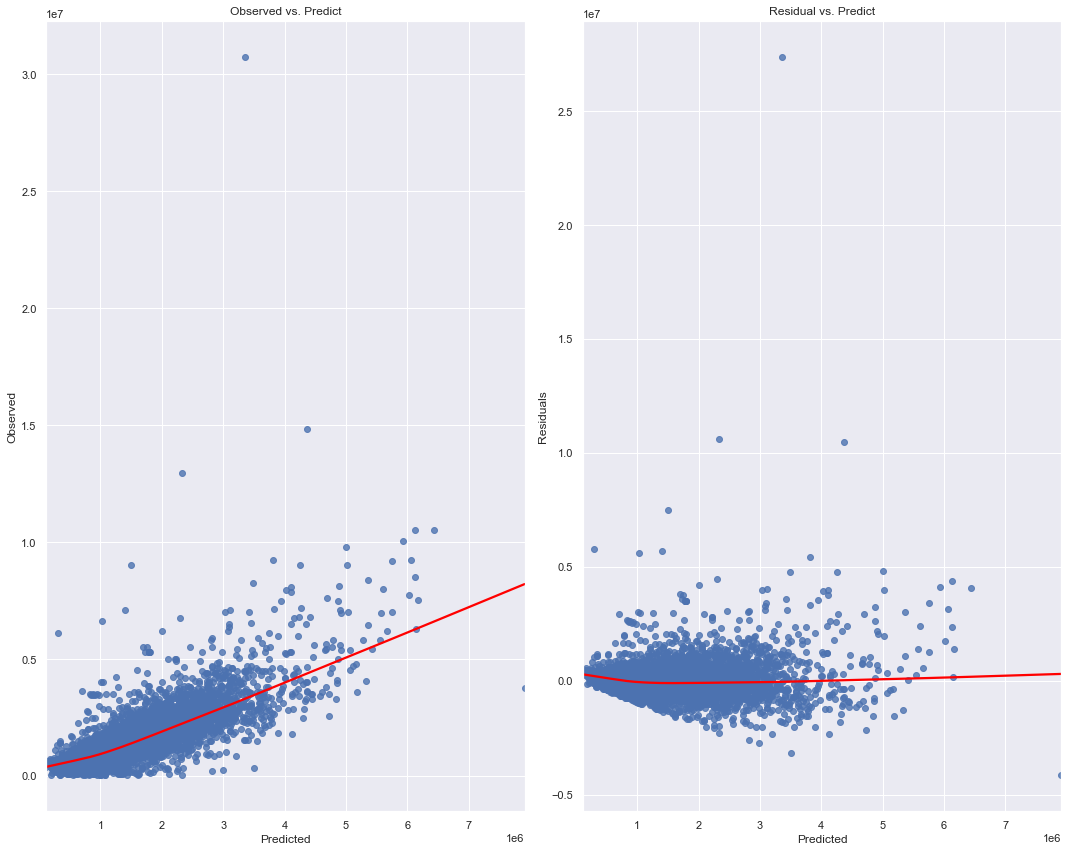

In [15]:
fitted_vals = model_train.predict()
resids = model_train.resid

fig, ax = plt.subplots(1,2)

sns.regplot(x=fitted_vals, y=y_train, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Observed vs. Predict')
ax[0].set(xlabel='Predicted', ylabel='Observed');

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Residual vs. Predict')
ax[1].set(xlabel='Predicted', ylabel='Residuals')

fig.tight_layout()

#### Rainbow Test

In [16]:
linear_rainbow(model_train)

(1.5268037416850888, 6.0263021288855446e-90)

Since the p value is below alpha, we reject the null hypothesis and do not consider the relationship to be linear. We will need to perform a non-linear transformation on either the target and/or features.

## Independence

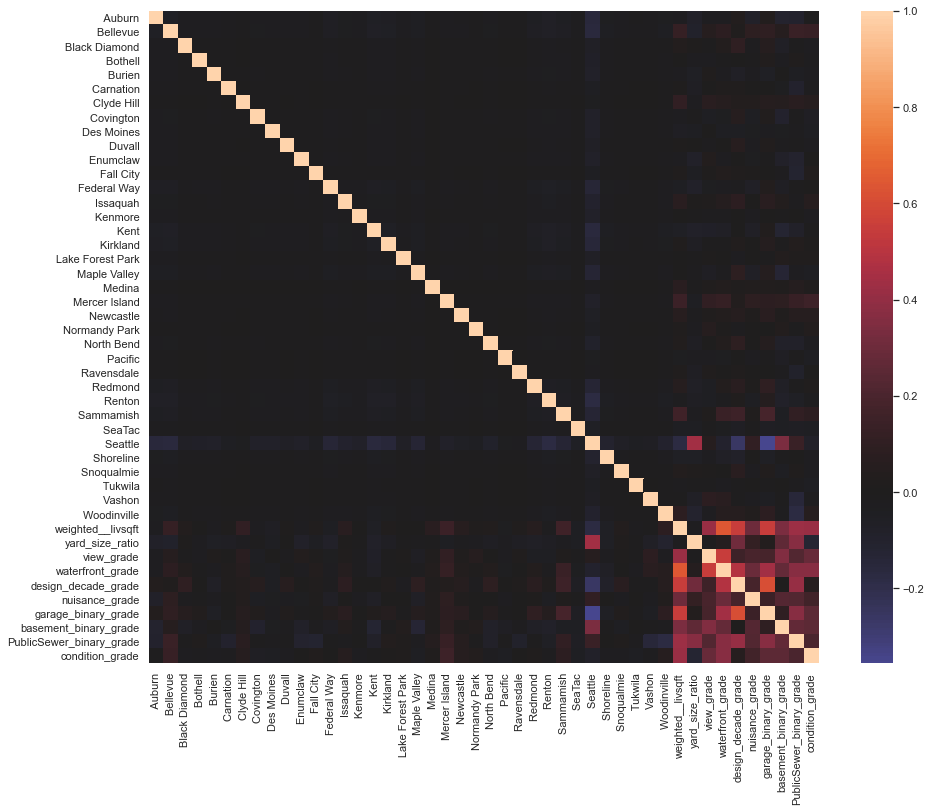

In [17]:
sns.heatmap(X_train.corr(), center=0);

In [18]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_corr=X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_corr

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))

# set index to pairs
df_corr.set_index(['pairs'], inplace = True)

#d rop level columns
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_corr.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df_corr.drop_duplicates(inplace=True)

df_corr[(df_corr.cc>.75) & (df_corr.cc <1)]

,cc
pairs,


We can see that none of the variables have a correlation of above 0.75, and so our model can be considered to be independent and have no multicollinearity.

## Normality

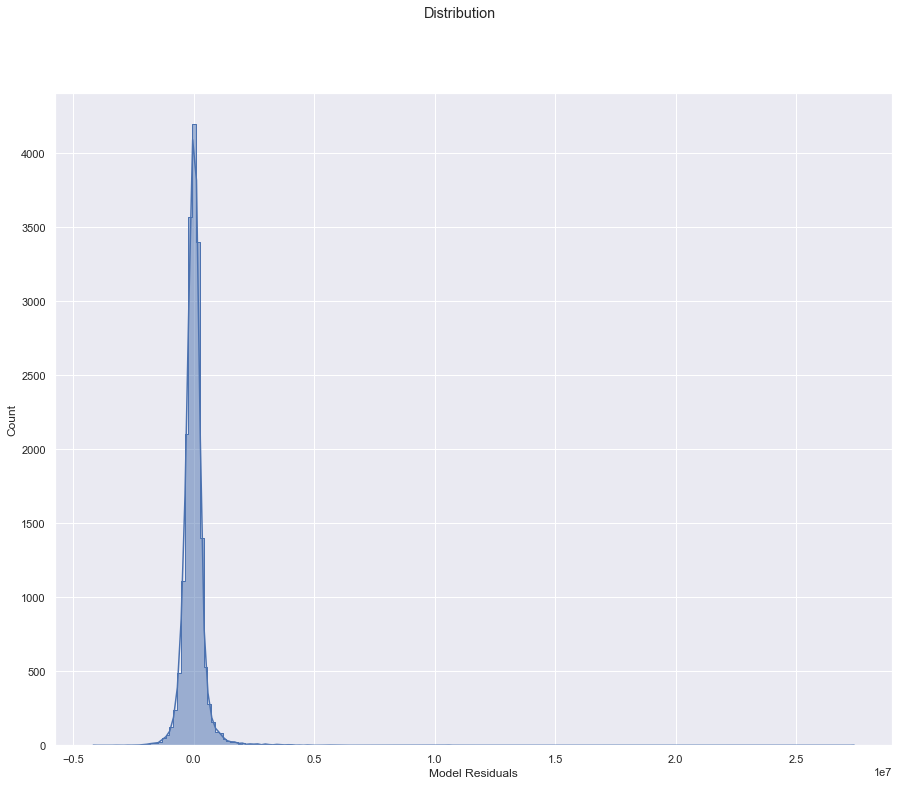

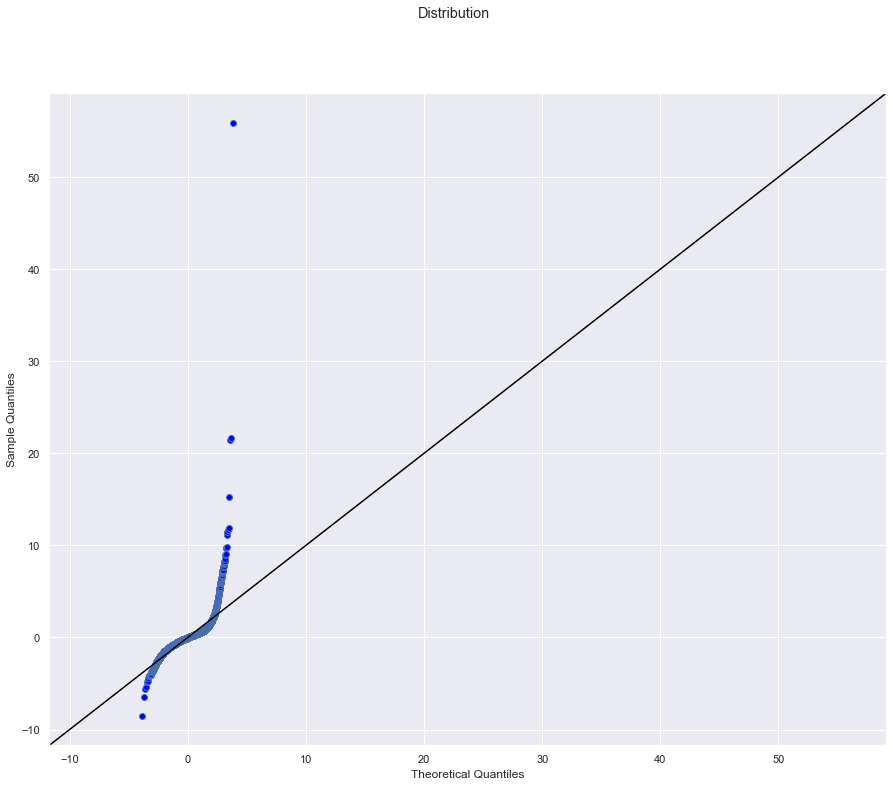

In [20]:
# Histogram of residuals
fig, ax = plt.subplots()
sns.histplot(model_train.resid, bins=200, element="step", kde=True, ax=ax)
ax.set_xlabel("Model Residuals")
fig.suptitle("Distribution");

# Q-Q plot
# Use qqplot function from StatsModels
fig, ax = plt.subplots()
sm.graphics.qqplot(model_train.resid, dist=stats.norm, line='45', fit=True, ax=ax)

# Customize plot appearance
line = ax.lines[1]
line.set_color("black")
fig.suptitle("Distribution");

In [22]:
jarque_bera(model_train.resid)

(252443597.83748937, 0.0, 12.453591434924258, 579.557611623069)

To determine the normality of the model, we can look at the histogram of residuals and QQ plot. We can also reference the Jarque-Bera test results.

- We can reject the null hypothesis as the residual P value is below alpha, and so the distribution is not normal.
- The fix is to transform non-normal features or the target by applying a log transform.

## Equal Variance

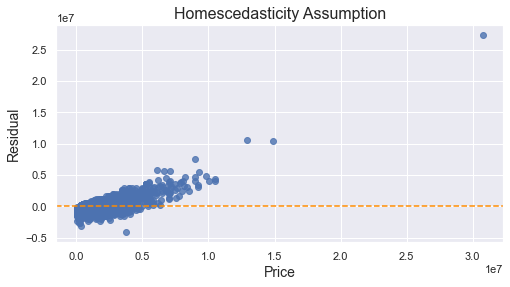

In [21]:
# Plotting the residuals
plt.subplots(figsize=(8, 4))
plt.scatter(x=y_train, y=model_train.resid, alpha=0.8)
plt.axhline(y=0, color='darkorange', linestyle='--')

plt.ylabel('Residual', fontsize=14)
plt.xlabel('Price', fontsize=14)
plt.title('Homescedasticity Assumption', fontsize=16)
plt.show();

In [23]:
# Goldfeld-Quandt test:
het_goldfeldquandt(y_train, X_train, alternative='two-sided')

(0.7035513871027496, 1.7850119799274474e-62, 'two-sided')

For this data, we have a p value below alpha. We can reject the null hypothesis, so the model is heteroscedastic.

Overall, it looks like our model only satisfies the independence tenet of the assumptions. We'll dig back into why this is so and see if we can improve the inference model.

# Creating the Inference Model

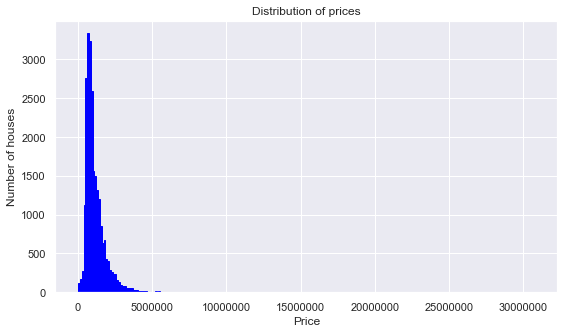

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (9,5))
df['price'].hist(bins=250, ax=ax, color='blue', ec='blue')
ax.ticklabel_format(style='plain')
plt.xlabel('Price')
plt.title('Distribution of prices')
plt.ylabel('Number of houses');

Here we see the housing prices spread. Although we tested this distribution to be non-normal in the above assumptions, we can also visually identify the same conclusion.

By applying a log transform to price, we can create a more normal distribution that can hopefully meet more of the assumptions for linear regression.

Note that we're only applying this transformation to our inference model. Explaining the log transform and results to stakeholders is not something we're able to do at this time.

We'll then apply this log transformed price to our model to see if it creates a better inference model.

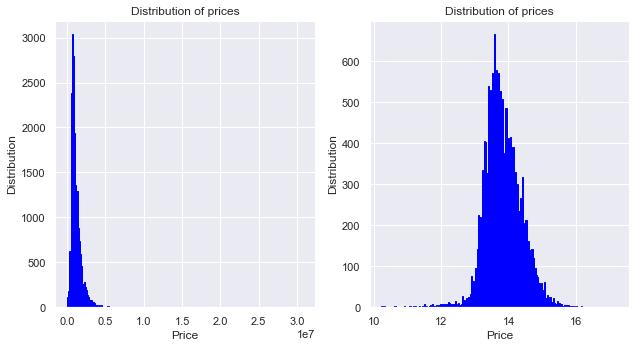

In [45]:
# Price
fig, ax = plt.subplots(1, 2, figsize = (9,5))


y_train.hist(bins=200, ax=ax[0], color='blue', ec='blue')
# ax[0].ticklabel_format(style='plain')
# ax[0].xlabel('Price')
# ax[0].title('Distribution of prices')
# ax[0].ylabel('Number of houses')
ax[0].set_title('Distribution of prices')
ax[0].set(xlabel='Price', ylabel='Distribution');


y_train_log = np.log(y_train)
y_train_log.hist(bins=200, ax=ax[1], color='blue', ec='blue')
ax[1].ticklabel_format(style='plain')
# ax[1].xlabel('Log(Price)')
# ax[1].title('Distribution of prices')
# ax[1].ylabel('Number of houses')
ax[1].set_title('Distribution of prices')
ax[1].set(xlabel='Price', ylabel='Distribution');
fig.tight_layout()
plt.show();

y_train = y_train_log

In [46]:
model_train = sm.OLS(y_train, sm.add_constant(X_train)).fit()
results_train = model_train.summary()
results_train

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     774.6
Date:                Sat, 06 Aug 2022   Prob (F-statistic):               0.00
Time:                        22:24:43   Log-Likelihood:                -5231.7
No. Observations:               18192   AIC:                         1.056e+04
Df Residuals:                   18146   BIC:                         1.091e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       12.5117      0.019    654.207      0.000      12.474      12.549
 Auburn                     -0.0609      0.011     -5.391      0.000      -0.083      -0.039
 Bellevue                    0.7388      0.011     66.996      0.000       0.717       0.760
 Black Diamond               0.0720      0.023      3.069      0.002       0.026       0.118
 Bothell                     0.5188      0.023     23.051      0.000       0.475       0.563
 Burien                      0.1123      0.019      5.811      0.000       0.074       0.150
 Carnation                   0.2976      0.032      9.177      0.000       0.234       0.361
 Clyde Hill                  1.1496      0.047     24.208      0.000       1.057       1.243
 Covington                   0.0292      0.019      1.555      0.120      -0.008       0.066
 Des Moines                 -0.0132      0.020     -0.647      0.518      -0.053       0.027
 Duvall                      0.2921      0.024     12.028      0.000       0.244       0.340
 Enumclaw                   -0.0283      0.020     -1.392      0.164      -0.068       0.012
 Fall City                   0.5264      0.039     13.454      0.000       0.450       0.603
 Federal Way                -0.1127      0.012     -9.106      0.000      -0.137      -0.088
 Issaquah                    0.5429      0.017     31.933      0.000       0.510       0.576
 Kenmore                     0.4047      0.021     19.597      0.000       0.364       0.445
 Kent                       -0.0294      0.011     -2.739      0.006      -0.050      -0.008
 Kirkland                    0.7239      0.012     62.278      0.000       0.701       0.747
 Lake Forest Park            0.4150      0.025     16.389      0.000       0.365       0.465
 Maple Valley                0.1553      0.014     11.497      0.000       0.129       0.182
 Medina                      1.2684      0.059     21.598      0.000       1.153       1.384
 Mercer Island               0.7765      0.021     37.021      0.000       0.735       0.818
 Newcastle                   0.4736      0.028     17.125      0.000       0.419       0.528
 Normandy Park               0.2361      0.037      6.395      0.000       0.164       0.309
 North Bend                  0.3239      0.018     17.657      0.000       0.288       0.360
 Pacific                    -0.1220      0.047     -2.615      0.009      -0.213      -0.031
 Ravensdale                  0.2194      0.050      4.366      0.000       0.121       0.318
 Redmond                     0.6690      0.013     52.032      0.000       0.644       0.694
 Renton                      0.1709      0.010     16.654      0.000       0.151       0.191
 Sammamish                   0.6178      0.013     48.003      0.000       0.593       0.643
 SeaTac       

We can see that our R-squared improved slightly, which means this model does explain the data better than the model with non-transformed target.

# Testing Inference Model for Linear Regression Assumptions

#### Linearity

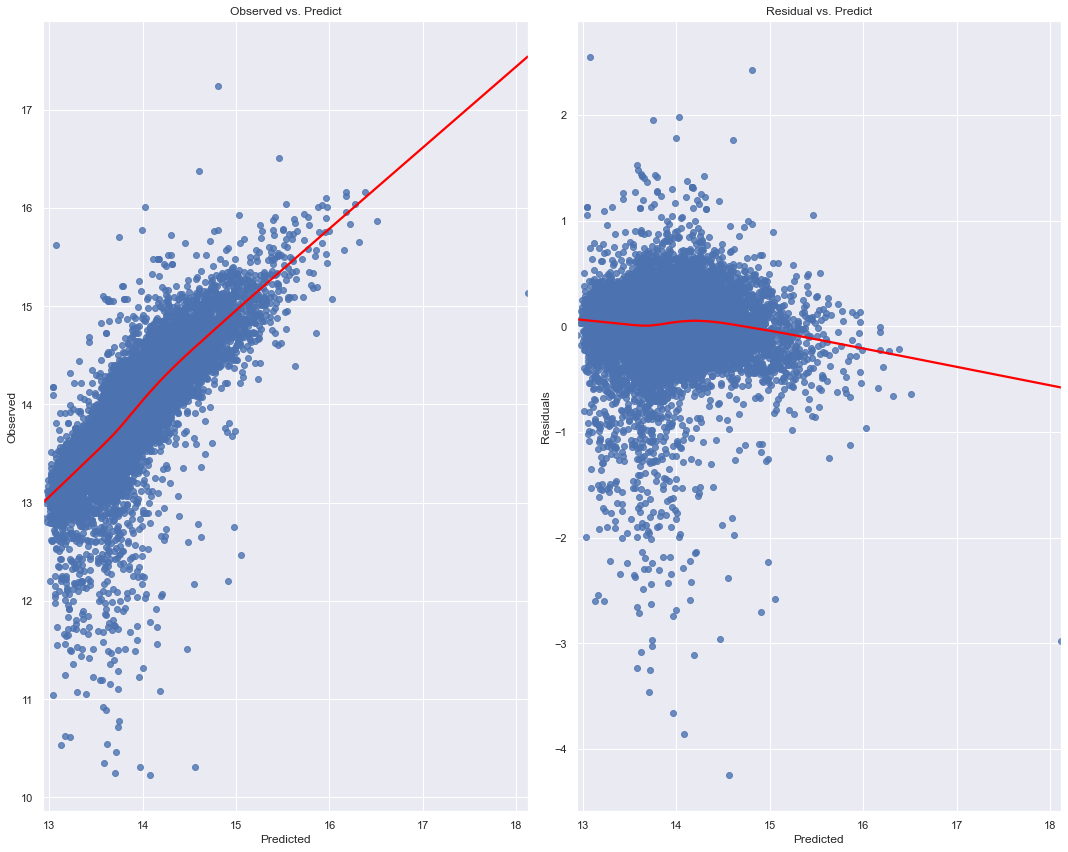

In [47]:
fitted_vals = model_train.predict()
resids = model_train.resid

fig, ax = plt.subplots(1,2)

sns.regplot(x=fitted_vals, y=y_train, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Observed vs. Predict')
ax[0].set(xlabel='Predicted', ylabel='Observed');

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Residual vs. Predict')
ax[1].set(xlabel='Predicted', ylabel='Residuals')

fig.tight_layout()

In [48]:
linear_rainbow(model_train)

(0.9957072089002655, 0.5811752342408887)

Since the p value from the rainbow test is above alpha, we cannot reject the null hypothesis and do so consider the relationship to be linear.

#### Independence

,cc
pairs,


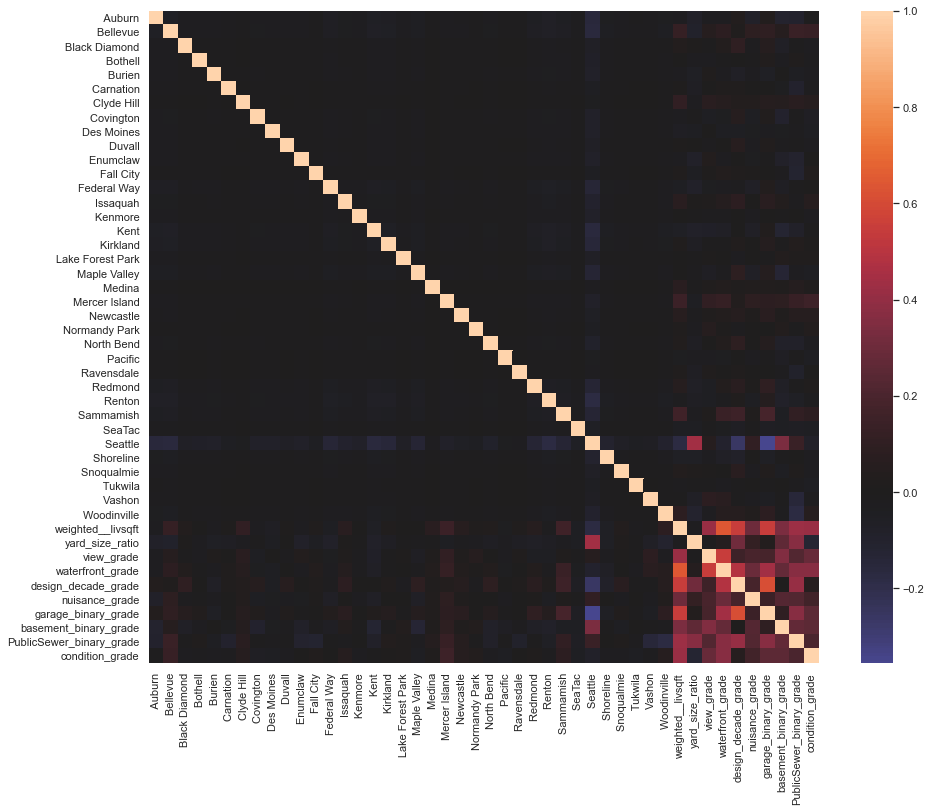

In [49]:
sns.heatmap(X_train.corr(), center=0);

# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_corr=X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_corr

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))

# set index to pairs
df_corr.set_index(['pairs'], inplace = True)

#d rop level columns
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df_corr.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df_corr.drop_duplicates(inplace=True)

df_corr[(df_corr.cc>.75) & (df_corr.cc <1)]

We can see there are no collinear factors, so our inputs can be considered to be independent.

#### Normality

(280060.389291609, 0.0, -2.2927657275244506, 21.666700575264755)

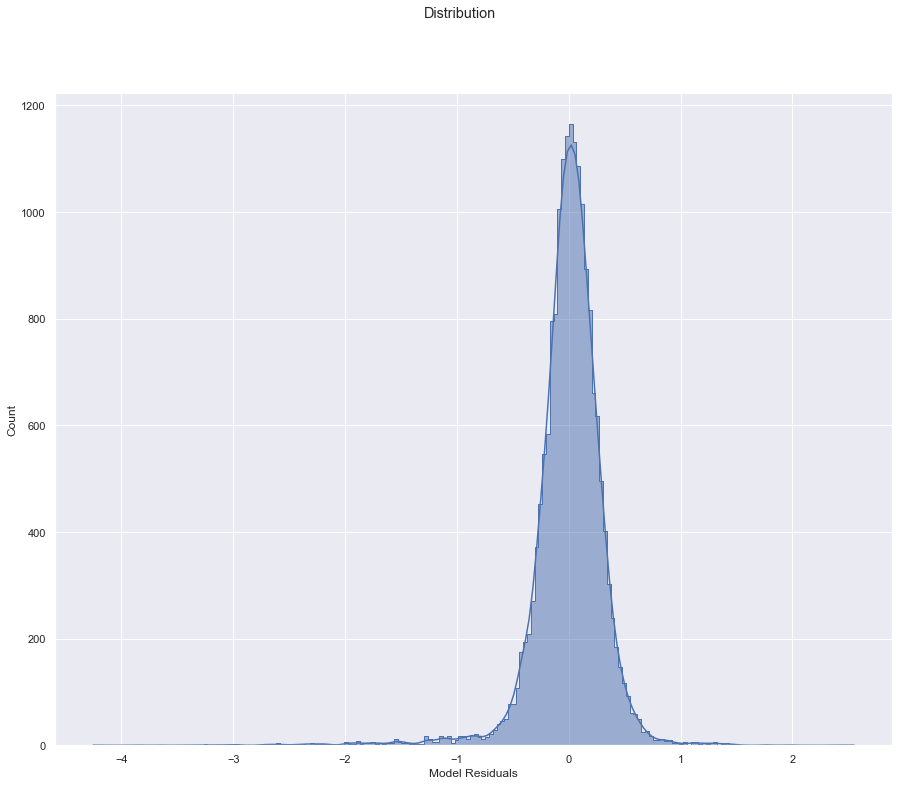

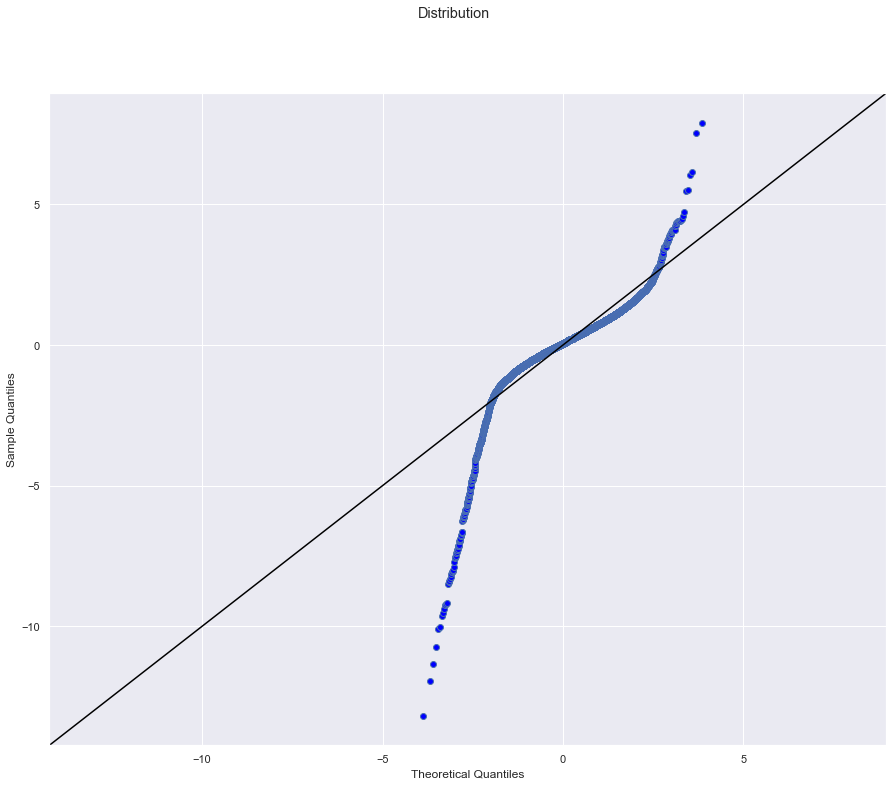

In [51]:
# Histogram of residuals
fig, ax = plt.subplots()
sns.histplot(model_train.resid, bins=200, element="step", kde=True, ax=ax)
ax.set_xlabel("Model Residuals")
fig.suptitle("Distribution");

# Q-Q plot
# Use qqplot function from StatsModels
fig, ax = plt.subplots()
sm.graphics.qqplot(model_train.resid, dist=stats.norm, line='45', fit=True, ax=ax)

# Customize plot appearance
line = ax.lines[1]
line.set_color("black")
fig.suptitle("Distribution");

jarque_bera(model_train.resid)

To determine the normality of the model, we can look at the histogram of residuals and QQ plot. We can also reference the Jarque-Bera test results.

We can reject the null hypothesis as the residual P value is below alpha, and so the distribution is still not normal.

#### Equal Variance

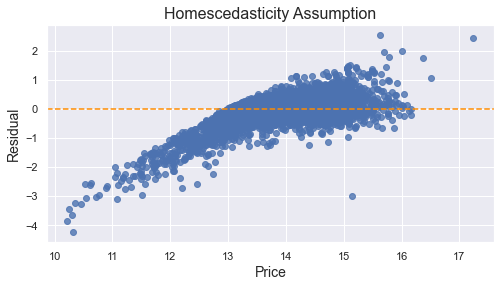

(1.0349128429183256, 0.10262922102887682, 'two-sided')

In [52]:
# Plotting the residuals
plt.subplots(figsize=(8, 4))
plt.scatter(x=y_train, y=model_train.resid, alpha=0.8)
plt.axhline(y=0, color='darkorange', linestyle='--')

plt.ylabel('Residual', fontsize=14)
plt.xlabel('Price', fontsize=14)
plt.title('Homescedasticity Assumption', fontsize=16)
plt.show();

# Goldfeld-Quandt test:
het_goldfeldquandt(y_train, X_train, alternative='two-sided')

For this data, we have a p value above alpha. We cannot reject the null hypothesis, so the model is homoscedastic.

# Recommendations / Conclusions


Based on our data analysis and the visualizations above, here are some key recommendations for King County Development to consider:

   1. The bigger the house, the higher the price. That said, we recommend houses at least in the 2,000 sqft range to garner higher interest from your average family and allow King County Development to control costs.
    
   2. The top home prices were generally in Medina, Clyde Hill, Mercer Island. 

   3. Build quality (i.e. grade) matters. This could be due to multiple factors, such as the impact of weather (rain and snow), the county being right off the shoreline, and the fact that people in this area command a higher salary and expect a higher overall build quality.

   4. Waterfronts and nicer views typically command a higher price. Even if shorelines are fully developed, King County Development should consider creating "man-made" lakes near areas that have a good view of the mountains or developing in areas that have access to natural bodies of water.
   
We were also able to create both an inferential and predictive model, which were analyzed to see if they meet the assumptions of linear regression and error.

   1. Our predictive model only meets one of the tenets of linear regression. Our inferential model, that uses log(price), is able to meet all assumptions of linear regression except having a normal distribution. We would continue to work on this model and it's variables given additional time.
   
   2. Our predictive model has an MAE of $270000, and an RMSE of $490000.